### Load libs

In [2]:
pip install ridgeplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 708.5 kB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pwd

'/content'

In [5]:
cd /content/drive/MyDrive/캡스톤/gluformer-master/

/content/drive/MyDrive/캡스톤/gluformer-master


In [6]:
pip install torch==1.13.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 74.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.13.0 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.13.0 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 1.13.0 whic

In [7]:
import time
import numpy as np
import matplotlib.pylab as plt
from ridgeplot import ridgeplot
from scipy.stats import norm
import pandas as pd
import random
import os

import torch
import torch
from torch.utils.data import Dataset, DataLoader

from gluformer.attention import *
from gluformer.encoder import *
from gluformer.decoder import *
from gluformer.embed import *
from gluformer.model import *
from utils.train import *

In [8]:
# define save path
save_path = './trials/trial_exp'
if not os.path.exists(save_path):
    os.makedirs(save_path)
# define cache path
cache_path = 'cache/visualize_experiment'
if not os.path.exists(cache_path):
    os.makedirs(cache_path)


### Create data generator

In [9]:
# generate mean with multi-modal behavior
random.seed(0)
def generate_mean(off, modes, lens, betas):
    mean = np.zeros(sum(lens))
    mean[:lens[0]] = off + \
                    np.sin((2*np.pi / 3) * np.arange(0, lens[0], 1)) * betas[0, 0] + \
                    np.cos((2*np.pi / 7) * np.arange(0, lens[0], 1)) * betas[0, 1]
    state = random.randint(0, 1)
    mean[lens[0]:sum(lens)] = off + modes[state] + \
                            np.sin((2*np.pi / 3) * np.arange(lens[0], sum(lens), 1)) * betas[1+state, 0] + \
                            np.cos((2*np.pi / 7) * np.arange(lens[0], sum(lens), 1)) * betas[1+state, 1]

    return mean

In [10]:
# generate the covariance matrix and sample from the Gaussian distribution \
# with specified mean and covariance
lens = [5, 9]
modes = [-10, 10]
off = 0
betas = np.array([[0.5, 0.5], [0.3, 0.7], [0.7, 0.3]])

cov = np.zeros((sum(lens), sum(lens)))
row = np.array([1] + [1 / abs(i) for i in range(1, sum(lens))])
for i in range(sum(lens)):
    cov[i, :(i+1)] = np.flip(row[:(i+1)])
    cov[i, (i+1):] = row[1:(sum(lens)-i)]
np.fill_diagonal(cov, 2)

train_samples = 2000
val_samples = 100

train_data = []
val_data = []
test_data = []
for i in range(train_samples):
    if i < val_samples:
        val_data.append([0,
                        np.random.multivariate_normal(generate_mean(off, modes, lens, betas), cov).reshape((-1, 1)),
                        np.arange(sum(lens), dtype=np.float32).reshape((-1, 1))])
        test_data.append([0,
                        np.random.multivariate_normal(generate_mean(off, modes, lens, betas), cov).reshape((-1, 1)),
                        np.arange(sum(lens), dtype=np.float32).reshape((-1, 1))])

    train_data.append([0,
                    np.random.multivariate_normal(generate_mean(off, modes, lens, betas), cov).reshape((-1, 1)),
                    np.arange(sum(lens), dtype=np.float32).reshape((-1, 1))])

In [11]:
# scale the data to [0, 1] using the min and max of the training data
maxx = np.max([train_data[i][1].max() for i in range(len(train_data))])
minn = np.min([train_data[i][1].min() for i in range(len(train_data))])

train_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / sum(lens)] for data in train_data]

val_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / sum(lens)] for data in val_data]


test_data = [[data[0],
              (data[1] - minn) / (maxx - minn),
              data[2] / sum(lens)] for data in test_data]

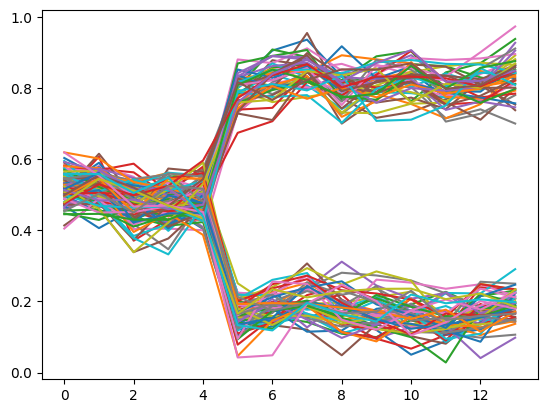

In [12]:
# plot test samples
plot_test = np.vstack([data[1].reshape((1, -1)) for data in test_data])
out = plt.plot(plot_test.transpose())
plt.show()
# save full data
np.save(f"{cache_path}/test_data.npy", plot_test)

### Create PyTorch data set

In [13]:
class Data(Dataset):
  def __init__(self, data, flag='train', size=None):
    # size [seq_len, label_len, pred_len]
    # info
    self.seq_len = size[0]
    self.label_len = size[1]
    self.pred_len = size[2]

    # init
    self.data = data
    len_segs = np.array([len(subj_seg[1]) for subj_seg in self.data])
    len_segs = len_segs - self.seq_len - self.pred_len + 1
    self.len_segs = np.insert(np.cumsum(len_segs), 0, 0)

  def __getitem__(self, index):

    idx_seg = np.argmax(self.len_segs > index) - 1
    seg = self.data[idx_seg]

    s_begin = index - self.len_segs[idx_seg]
    s_end = s_begin + self.seq_len
    r_begin = s_end - self.label_len
    r_end = r_begin + self.label_len + self.pred_len

    subj_id = seg[0]
    seq_x = seg[1][s_begin:s_end]
    seq_y = seg[1][r_begin:r_end]
    seq_x_mark = seg[2][s_begin:s_end]
    seq_y_mark = seg[2][r_begin:r_end]

    return subj_id, seq_x, seq_y, seq_x_mark, seq_y_mark

  def __len__(self):
    return self.len_segs[-1]

In [14]:
len_seq, len_label, len_pred = 4, 2, 2

train_data = Data(train_data, size=[len_seq, len_label, len_pred])
val_data = Data(val_data, size=[len_seq, len_label, len_pred])
test_data = Data(test_data, size=[len_seq, len_label, len_pred])

### Define model

In [15]:
!nvidia-smi

Sat Apr 27 06:16:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
device = torch.device('cuda:0')
model = Gluformer(d_model=128,
                    n_heads=4,
                    d_fcn=256,
                    r_drop=0.3,
                    activ="relu",
                    num_enc_layers=2,
                    num_dec_layers=1,
                    distil=True,
                    len_seq=len_seq,
                    len_pred=len_pred,
                    num_features=1)
model.train()
model = model.to(device)

### Train with the infinite mixture objective

In [17]:
model_path = os.path.join(save_path, "model_inf_mixture.pth")
num_samples = 3 # number of samples for MC estimate
batch_size = 256 # batch size for optimization
collate_fn_custom = modify_collate(num_samples)

train_data_loader = DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True,
                                collate_fn = collate_fn_custom)

val_data_loader = DataLoader(val_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True,
                                collate_fn = collate_fn_custom)

test_data_loader = DataLoader(test_data,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0,
                                drop_last=True,
                                collate_fn = collate_fn_custom)


In [18]:
epochs = 100
criterion =  ExpLikeliLoss(num_samples)
model_optim = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0, 0.9))

# define params for training
TRAIN_STEPS = len(train_data_loader)
early_stop = EarlyStop(20, 1e-6)

for epoch in range(epochs):
    iter_count = 0
    train_loss = []

    epoch_time = time.time()
    curr_time = time.time()

    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_data_loader):
        iter_count += 1
        # zero-out grad
        model_optim.zero_grad()
        pred, true, logvar = process_batch(subj_id=subj_id,
                                            batch_x=batch_x,
                                            batch_y=batch_y,
                                            batch_x_mark=batch_x_mark,
                                            batch_y_mark=batch_y_mark,
                                            len_pred=len_pred,
                                            len_label=len_label,
                                            model=model,
                                            device=device)
        loss = criterion(pred, true, logvar)
        train_loss.append(float(loss.item()))

        # print every 10
        if (i+1) % 10==0:
            print("\t iters: {0} / {3}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item(), TRAIN_STEPS))
            logvar = logvar.reshape(-1, num_samples)
            print(f"\t variance shape: {logvar.shape}")
            print("\t variance: ", np.exp(logvar.detach().cpu().numpy()[0, :]))
            speed = (time.time() - curr_time) / iter_count
            left_time = speed * ((epochs - epoch) * TRAIN_STEPS - i)
            print('\t speed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            curr_time = time.time()

        loss.backward()
        model_optim.step()
    # compute average train loss
    train_loss = np.average(train_loss)

    # compute validation loss
    with torch.no_grad():
        val_loss = []
        for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(val_data_loader):
            pred, true, logvar = process_batch(subj_id = subj_id,
                                    batch_x=batch_x,
                                    batch_y=batch_y,
                                    batch_x_mark=batch_x_mark,
                                    batch_y_mark=batch_y_mark,
                                    len_pred=len_pred,
                                    len_label=len_label,
                                    model=model,
                                    device=device)
            loss = criterion(pred, true, logvar)
            val_loss.append(float(loss.item()))
        val_loss = np.average(val_loss)

    # check early stopping
    early_stop(val_loss, model, model_path)
    if early_stop.stop:
        print("Early stopping...")
        break

    # update lr
    # adjust_learning_rate(model_optim, epoch, lr)

    print("Epoch: {0} Time: {1} Steps: {2}".format(epoch+1, time.time() - epoch_time, TRAIN_STEPS))
    print("Train Loss: {0:.7f} | Val Loss: {1:.7f}".format(train_loss, val_loss))

	 iters: 10 / 70, epoch: 1 | loss: 1.0250289
	 variance shape: torch.Size([256, 3])
	 variance:  [19.57976     0.11624458 10.728839  ]
	 speed: 0.6004s/iter; left time: 4197.6684s
	 iters: 20 / 70, epoch: 1 | loss: 0.1734299
	 variance shape: torch.Size([256, 3])
	 variance:  [381.63974     7.8885508 700.86865  ]
	 speed: 0.0483s/iter; left time: 336.9961s
	 iters: 30 / 70, epoch: 1 | loss: -0.5819773
	 variance shape: torch.Size([256, 3])
	 variance:  [19.924171   0.8208381  1.2293632]
	 speed: 0.0372s/iter; left time: 259.0352s
	 iters: 40 / 70, epoch: 1 | loss: -1.2109239
	 variance shape: torch.Size([256, 3])
	 variance:  [30.991398    0.20580539  3.0341358 ]
	 speed: 0.0392s/iter; left time: 272.8516s
	 iters: 50 / 70, epoch: 1 | loss: -1.5784363
	 variance shape: torch.Size([256, 3])
	 variance:  [0.02829468 0.4926494  0.4003346 ]
	 speed: 0.0353s/iter; left time: 245.1576s
	 iters: 60 / 70, epoch: 1 | loss: -1.8174469
	 variance shape: torch.Size([256, 3])
	 variance:  [12.81515

### Test infinite mixture model

In [19]:
model.train()
calibration = [[] for i in range(len_pred)]
ape, rmse = [], []
with torch.no_grad():
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
        pred, true, logvar = process_batch(subj_id = subj_id,
                                batch_x=batch_x,
                                batch_y=batch_y,
                                batch_x_mark=batch_x_mark,
                                batch_y_mark=batch_y_mark,
                                len_pred=len_pred,
                                len_label=len_label,
                                model=model,
                                device=device)

        # arrange in proper shape: take mean of predicted samples
        pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy(); logvar = logvar.detach().cpu().numpy()
        pred = pred.transpose((1,0,2)).reshape((pred.shape[1], -1, num_samples)).transpose((1, 0, 2))
        true = true.transpose((1,0,2)).reshape((true.shape[1], -1, num_samples)).transpose((1, 0, 2))
        logvar = logvar.transpose((1,0,2)).reshape((logvar.shape[1], -1, num_samples)).transpose((1, 0, 2))

        # calculate calibration
        for k in range(batch_size):
            for i in range(len_pred):
                ps = [norm.cdf(true[k, i, 0], pred[k, i, j], np.sqrt(np.exp(logvar[k, 0, j])))
                        for j in range(num_samples)]
                p = np.average(ps)
                calibration[i].append(p)

        # for metrics: take mean of smaples, take one sample of true
        pred = np.mean(pred, axis=2)
        true = true[:, :, 0]
        # compute APE / RMSE
        ape.append(np.mean(np.abs(true - pred) / true))
        rmse.append(np.sqrt(np.mean((true - pred)**2)))

rmse = np.median(rmse)
ape = np.median(ape)
print("APE: {0:.4f}".format(ape))
print("RMSE: {0:.4f}".format(rmse))

APE: 0.3982
RMSE: 0.1614


In [20]:
# save for plotting
num_samples=5 # increase number of samples from posterior
collate_fn_custom = modify_collate(num_samples)
test_data_loader = DataLoader(test_data,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0,
                                drop_last=True,
                                collate_fn = collate_fn_custom)

with torch.no_grad():
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
        pred, true, logvar = process_batch(subj_id = subj_id,
                                batch_x=batch_x,
                                batch_y=batch_y,
                                batch_x_mark=batch_x_mark,
                                batch_y_mark=batch_y_mark,
                                len_pred=len_pred,
                                len_label=len_label,
                                model=model,
                                device=device)

        # arrange in proper shape: take mean of predicted samples
        pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy()
        batch_x = batch_x.detach().cpu().numpy(); logvar = logvar.detach().cpu().numpy()
        batch_x_mark = batch_x_mark.detach().cpu().numpy()
        pred = pred.transpose((1,0,2)).reshape((pred.shape[1], -1, num_samples)).transpose((1, 0, 2))
        true = true.transpose((1,0,2)).reshape((true.shape[1], -1, num_samples)).transpose((1, 0, 2))
        logvar = logvar.transpose((1,0,2)).reshape((logvar.shape[1], -1, num_samples)).transpose((1, 0, 2))
        batch_x = batch_x.transpose((1,0,2)).reshape((batch_x.shape[1], -1, num_samples)).transpose((1, 0, 2))
        batch_x_mark = batch_x_mark.transpose((1,0,2)).reshape((batch_x_mark.shape[1], -1, num_samples)).transpose((1, 0, 2))
        break
# save
np.save(f"{cache_path}/pred_mean_infmixt.npy", pred)
np.save(f"{cache_path}/true_mean_infmixt.npy", true)
np.save(f"{cache_path}/pred_logvar_infmixt.npy", logvar)
np.save(f"{cache_path}/input_infmixt.npy", batch_x)
np.save(f"{cache_path}/input_x_norm.npy", batch_x_mark)

### Define model

In [21]:
device = torch.device('cuda:0')
model = Gluformer(d_model=128,
                    n_heads=4,
                    d_fcn=64,
                    r_drop=0.,
                    activ="relu",
                    num_enc_layers=2,
                    num_dec_layers=1,
                    distil=True,
                    len_seq=len_seq,
                    len_pred=len_pred,
                    num_features=1)
model.train()
model = model.to(device)

### Train with the MSE

In [22]:
model_path = os.path.join(save_path, "model_norm.pth")
num_samples = 1
batch_size = 256 # batch size for optimization
collate_fn_custom = modify_collate(num_samples)

train_data_loader = DataLoader(train_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True,
                                collate_fn = collate_fn_custom)

val_data_loader = DataLoader(val_data,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True,
                                collate_fn = collate_fn_custom)

test_data_loader = DataLoader(test_data,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0,
                                drop_last=True,
                                collate_fn = collate_fn_custom)


In [23]:
epochs = 100
criterion = nn.MSELoss()
model_optim = torch.optim.Adam(model.parameters(), lr=0.0002, betas=(0, 0.9))

# define params for training
TRAIN_STEPS = len(train_data_loader)
early_stop = EarlyStop(20, 1e-6)

for epoch in range(epochs):
    iter_count = 0
    train_loss = []

    epoch_time = time.time()
    curr_time = time.time()

    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(train_data_loader):
        iter_count += 1
        # zero-out grad
        model_optim.zero_grad()
        pred, true, logvar = process_batch(subj_id=subj_id,
                                            batch_x=batch_x,
                                            batch_y=batch_y,
                                            batch_x_mark=batch_x_mark,
                                            batch_y_mark=batch_y_mark,
                                            len_pred=len_pred,
                                            len_label=len_label,
                                            model=model,
                                            device=device)
        loss = criterion(pred, true)
        train_loss.append(float(loss.item()))

        # print every 10
        if (i+1) % 10==0:
            print("\t iters: {0} / {3}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item(), TRAIN_STEPS))
            speed = (time.time() - curr_time) / iter_count
            left_time = speed * ((epochs - epoch) * TRAIN_STEPS - i)
            print('\t speed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
            iter_count = 0
            curr_time = time.time()

        loss.backward()
        model_optim.step()
    # compute average train loss
    train_loss = np.average(train_loss)

    # compute validation / test loss + test metric
    with torch.no_grad():
        val_loss = []
        for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(val_data_loader):
            pred, true, logvar = process_batch(subj_id = subj_id,
                                    batch_x=batch_x,
                                    batch_y=batch_y,
                                    batch_x_mark=batch_x_mark,
                                    batch_y_mark=batch_y_mark,
                                    len_pred=len_pred,
                                    len_label=len_label,
                                    model=model,
                                    device=device)
            loss = criterion(pred, true)
            val_loss.append(float(loss.item()))
        val_loss = np.average(val_loss)

    # check early stopping
    early_stop(val_loss, model, model_path)
    if early_stop.stop:
        print("Early stopping...")
        break

    # update lr
    # adjust_learning_rate(model_optim, epoch, lr)

    print("Epoch: {0} Time: {1} Steps: {2}".format(epoch+1, time.time() - epoch_time, TRAIN_STEPS))
    print("Train Loss: {0:.7f} | Val Loss: {1:.7f}".format(train_loss, val_loss))

	 iters: 10 / 70, epoch: 1 | loss: 0.0461792
	 speed: 0.0407s/iter; left time: 284.8458s
	 iters: 20 / 70, epoch: 1 | loss: 0.0315717
	 speed: 0.0399s/iter; left time: 278.2785s
	 iters: 30 / 70, epoch: 1 | loss: 0.0510776
	 speed: 0.0471s/iter; left time: 328.4193s
	 iters: 40 / 70, epoch: 1 | loss: 0.0635152
	 speed: 0.0429s/iter; left time: 298.4683s
	 iters: 50 / 70, epoch: 1 | loss: 0.0216273
	 speed: 0.0424s/iter; left time: 294.8787s
	 iters: 60 / 70, epoch: 1 | loss: 0.0404593
	 speed: 0.0409s/iter; left time: 284.1515s
	 iters: 70 / 70, epoch: 1 | loss: 0.0233652
	 speed: 0.0290s/iter; left time: 201.0550s
Validation loss descreased: inf -> 0.03737621381878853
Epoch: 1 Time: 2.918323516845703 Steps: 70
Train Loss: 0.0408658 | Val Loss: 0.0373762
	 iters: 10 / 70, epoch: 2 | loss: 0.0240875
	 speed: 0.0274s/iter; left time: 189.5312s
	 iters: 20 / 70, epoch: 2 | loss: 0.0188114
	 speed: 0.0291s/iter; left time: 200.9240s
	 iters: 30 / 70, epoch: 2 | loss: 0.0419296
	 speed: 0.0

## Test normal model

In [24]:
model.eval()
ape, rmse, likelihood = [], [], []
with torch.no_grad():
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
        pred, true, logvar = process_batch(subj_id = subj_id,
                                batch_x=batch_x,
                                batch_y=batch_y,
                                batch_x_mark=batch_x_mark,
                                batch_y_mark=batch_y_mark,
                                len_pred=len_pred,
                                len_label=len_label,
                                model=model,
                                device=device)

        # arrange in proper shape: take mean of predicted samples
        pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy(); logvar = logvar.detach().cpu().numpy()
        pred = pred.transpose((1,0,2)).reshape((pred.shape[1], -1, num_samples)).transpose((1, 0, 2))
        true = true.transpose((1,0,2)).reshape((true.shape[1], -1, num_samples)).transpose((1, 0, 2))
        # for metrics: take mean of smaples, take one sample of true
        pred = np.mean(pred, axis=2)
        true = true[:, :, 0]
        # compute APE / RMSE
        ape.append(np.mean(np.abs(true - pred) / true))
        rmse.append(np.sqrt(np.mean((true - pred)**2)))
        # compute likelihood for computing var later
        likelihood.append(np.mean((pred - true)**2, axis=1))

varhat = np.mean(np.concatenate(likelihood, axis=0))
rmse = np.median(rmse)
ape = np.median(ape)
print("APE: {0:.4f}".format(ape))
print("RMSE: {0:.4f}".format(rmse))

APE: 0.3802
RMSE: 0.1372


In [25]:
# save for plotting
with torch.no_grad():
    for i, (subj_id, batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
        pred, true, logvar = process_batch(subj_id = subj_id,
                                batch_x=batch_x,
                                batch_y=batch_y,
                                batch_x_mark=batch_x_mark,
                                batch_y_mark=batch_y_mark,
                                len_pred=len_pred,
                                len_label=len_label,
                                model=model,
                                device=device)

        # arrange in proper shape: take mean of predicted samples
        pred = pred.detach().cpu().numpy(); true = true.detach().cpu().numpy()
        batch_x = batch_x.detach().cpu().numpy(); batch_x_mark = batch_x_mark.detach().cpu().numpy()
        pred = pred.transpose((1,0,2)).reshape((pred.shape[1], -1, num_samples)).transpose((1, 0, 2))
        true = true.transpose((1,0,2)).reshape((true.shape[1], -1, num_samples)).transpose((1, 0, 2))
        batch_x = batch_x.transpose((1,0,2)).reshape((batch_x.shape[1], -1, num_samples)).transpose((1, 0, 2))
        batch_x_mark = batch_x_mark.transpose((1,0,2)).reshape((batch_x_mark.shape[1], -1, num_samples)).transpose((1, 0, 2))
        break
# save
np.save(f"{cache_path}/pred_mean_norm.npy", pred)
np.save(f"{cache_path}/true_mean_norm.npy", true)
np.save(f"{cache_path}/pred_var_norm.npy", np.array([varhat]))
np.save(f"{cache_path}/input_norm.npy", batch_x)
np.save(f"{cache_path}/input_x_norm.npy", batch_x_mark)


In [26]:
t = (8, *[1,2,3])

In [27]:
s = set(t)